# Chi Square

In [ ]:
#@title Imports

import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import math

from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic #new import
import statsmodels.api as sm

import ipywidgets as widgets
from IPython.display import display

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Define Functions
def log_likelihood(contingency_table):
    # Ensure the input array is a numpy array
    contingency_table = np.array(contingency_table)

    # Calculate the total number of observations
    total_obs = np.sum(contingency_table)

    # Calculate the expected frequencies for each cell
    row_totals = np.sum(contingency_table, axis=1, keepdims=True)
    col_totals = np.sum(contingency_table, axis=0, keepdims=True)
    expected_frequencies = np.dot(row_totals, col_totals) / total_obs

    # Avoid division by zero by adding a small value to expected frequencies
    expected_frequencies[expected_frequencies == 0] = 1e-10

    # Calculate the log-likelihood
    LL = np.sum(contingency_table * np.log(expected_frequencies / contingency_table))

    return LL

def uncertainty_r_squared(data, X_name, Y_name):
  # Calculate the entropy of Variable1
  entropy_var1 = stats.entropy(data[X_name].value_counts(), base=2)

  # Calculate the conditional entropy of Variable1 given Variable2
  conditional_entropy = 0
  for value in data[Y_name].unique():
      subset = data[data[Y_name] == value][X_name]
      conditional_entropy += (len(subset) / len(data)) * stats.entropy(subset.value_counts(), base=2)

  # Calculate Uncertainty R-Squared
  uncertainty_r_squared = 1 - (conditional_entropy / entropy_var1)
  return uncertainty_r_squared

In [ ]:
#@title #Download File and Select Data

#@markdown Make sure the file containing the data you wish to analyze is in your Google Drive
file_type = "xlsx" #@param ["csv", "xlsx"]
file_name = 'Hot Dogs.xlsx' #@param ["estradiol.csv", "Hot Dogs.xlsx"] {type:"string", allow-input: true}
# Hot Dogs.xlsx
#@markdown Check the below box to inspect the imported data.
show_frame = True #@param {type:"boolean"}
#@markdown Show just first five? (Reduces screen clutter)
first_five = True #@param {type:"boolean"}

file_path = f"/content/drive/MyDrive/{file_name}"

match file_type:
  case "csv":
    data = pd.read_csv(file_path)
  case "xlsx":
    data = pd.read_excel(file_path)

#@markdown ---
if show_frame:
  if first_five:
    display(data.head())
  else:
    display(data)

,Product Name,Type,Taste,$/oz,$/lb Protein,Calories,Sodium,Protein/Fat
0,Happy Hill Supers,Beef,Bland,0.11,14.23,186,495,1
1,Georgies Skinless Beef,Beef,Bland,0.17,21.70,181,477,2
2,Special Market's Premium Beef,Beef,Bland,0.11,14.49,176,425,1
3,Spike's Beef,Beef,Medium,0.15,20.49,149,322,1
4,Hungry Hugh's Jumbo Beef,Beef,Medium,0.10,14.47,184,482,1


In [ ]:
#@title #Select X, Factor and Y, Response

#give good errors in case of selecting continuous input / wrong input (look at Romeo's t-test)

#@markdown Make sure the variable names are spelled correctly and without quotation marks! Reference the table printed above.
X_name = "Type" #@param {type:"string"}
Y_name = "Taste" #@param {type:"string", allow-input: true}
# Hot Dogs.xlsx
print("Confirm that the variables have been selected correctly.\n")
display(data[[X_name, Y_name]].head(5))
print("...")

Confirm that the variables have been selected correctly.



,Type,Taste
0,Beef,Bland
1,Beef,Bland
2,Beef,Bland
3,Beef,Medium
4,Beef,Medium


...


# Contingency Analysis of X by Y

## Mosaic Plot

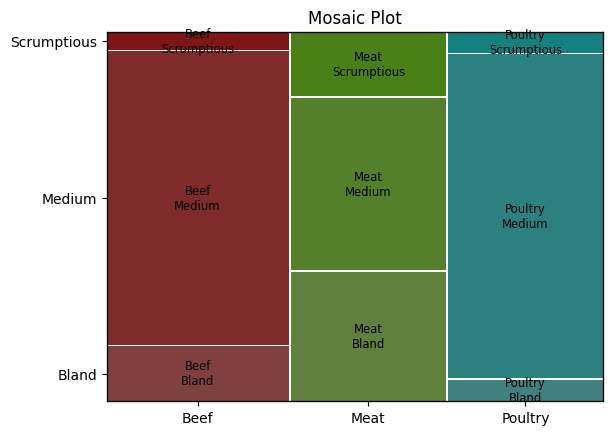

In [ ]:
#@title Mosaic Plot
mosaic(data,[X_name,Y_name])
plt.title("Mosaic Plot")
plt.show()

## Contingency Tables

In [ ]:
#@title Contingency Table
crosstable = pd.crosstab(data[X_name],data[Y_name],margins=True)
crosstable

Taste,Bland,Medium,Scrumptious,All
Type,,,,
Beef,3,16,1,20
Meat,6,8,3,17
Poultry,1,15,1,17
All,10,39,5,54


In [ ]:
#@title Contingency Table (Total %)
norm_crosstable = pd.crosstab(data[X_name],data[Y_name],margins=True,normalize='all')
norm_crosstable

Taste,Bland,Medium,Scrumptious,All
Type,,,,
Beef,0.055556,0.296296,0.018519,0.370370
Meat,0.111111,0.148148,0.055556,0.314815
Poultry,0.018519,0.277778,0.018519,0.314815
All,0.185185,0.722222,0.092593,1.000000


In [ ]:
#@title Contingency Table (Column %)
col_crosstable = pd.crosstab(data[X_name],data[Y_name],margins=True,normalize='columns')
col_crosstable

Taste,Bland,Medium,Scrumptious,All
Type,,,,
Beef,0.3,0.410256,0.2,0.370370
Meat,0.6,0.205128,0.6,0.314815
Poultry,0.1,0.384615,0.2,0.314815


In [ ]:
#@title Contingency Table (Row %)
row_crosstable = pd.crosstab(data[X_name],data[Y_name],margins=True,normalize='index')
row_crosstable

Taste,Bland,Medium,Scrumptious
Type,,,
Beef,0.150000,0.800000,0.050000
Meat,0.352941,0.470588,0.176471
Poultry,0.058824,0.882353,0.058824
All,0.185185,0.722222,0.092593


## Tests

In [ ]:
#@title Values
contingency_table = pd.crosstab(data[X_name],data[Y_name],margins=False)

chi2_res = stats.chi2_contingency(contingency_table)
loglike = log_likelihood(contingency_table)

data_1 = {
    'N': [len(data[[X_name,Y_name]])],
    'DF': [chi2_res.dof],
    '-LogLike': [-loglike],
    'RSquare (U)': [uncertainty_r_squared(data, X_name, Y_name)],
}

table_1 = pd.DataFrame(data_1, index=["Value"])
table_1

,N,DF,-LogLike,RSquare (U)
Value,54,4,4.16923,0.070472


In [ ]:
#@title Chi Square Tests
loglike_res = 1-stats.chi2.cdf(-2*loglike, chi2_res.dof)

data_2 = {
    'Test': ["Likelihood Ratio", "Pearson"],
    'ChiSquare': [-2*loglike, chi2_res.statistic],
    'Prob>ChiSquare': [loglike_res, chi2_res.pvalue]
}

table_2 = pd.DataFrame(data_2)
table_2

,Test,ChiSquare,Prob>ChiSquare
0,Likelihood Ratio,8.338460,0.079938
1,Pearson,8.337421,0.079971


In [ ]:
#@title Fisher's
if contingency_table.shape == (2,2):
  l_ratio, l_prob = stats.fisher_exact(contingency_table, alternative='less')
  r_ratio, r_prob = stats.fisher_exact(contingency_table, alternative='greater')
  tt_ratio, tt_prob = stats.fihser_exact(contingency_table, alternative='two-sided')

  fishers_data = {
      'Exact Test': ['Left', 'Right', '2 Tail'],
      'Prob': [l_prob, r_prob, tt_prob],
      'Alternative Hypothesis': [0,0,0]
  }

  fishers = pd.DataFrame(fishers_data)
  fishers